In [1]:
import pandas as pd
from tqdm import tqdm
from hopfield import *

In [2]:
# n nodes
# k images
# see if the images are fixed pts (not necessarily stable)
max_num_nodes_to_test = 100
remembrance_threshold = 0.05

In [3]:
def check_remembrance(network: Hopfield, image: np.array):
    network.values = image
    updated_values = network.do_synchronous_update()
    hamming_distance = network.hamming_distance(updated_values, image)
    try:
        assert hamming_distance <= int(0.05 * network.n)
        return True
    except AssertionError:
        # print(hamming_distance)
        return False

In [4]:
def check_multiple_remembrances(network: Hopfield, images: list[np.array]):
    for image in images:
        if not check_remembrance(network, image):
            return False
    return True

In [5]:
remembrance_data = {n: [] for n in range(2, max_num_nodes_to_test + 1)}

for n in tqdm(range(2, max_num_nodes_to_test + 1)):
    network = Hopfield(shape = (n, 1))
    network.train_on_values()
    images_trained_on = [np.array(network.values)]
    remembrance_data[n].append(check_multiple_remembrances(network, images_trained_on))
    while remembrance_data[n][-1] is True:
        random_image = network.generate_random_image()
        network.train_on_new(random_image)
        images_trained_on.append(random_image)
        remembrance_data[n].append(check_multiple_remembrances(network, images_trained_on))

100%|██████████| 99/99 [00:08<00:00, 11.92it/s] 


In [6]:
max([len(remembrance_data[n]) - 1 for n in range(2, max_num_nodes_to_test + 1)])

28

<Axes: xlabel='num nodes', ylabel='num remembered'>

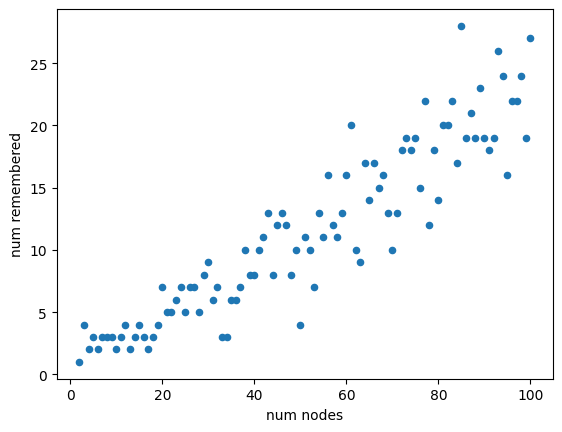

In [27]:
interpreted_data = {"num remembered": [len(remembrance_data[n]) - 1 for n in remembrance_data.keys()], "num nodes": [n for n in remembrance_data.keys()]}
# print(interpreted_data)
dataframe = pd.DataFrame(interpreted_data)
# print(dataframe)
dataframe.plot(x="num nodes", y="num remembered", kind="scatter")